# Experimento com dados de todos os poços

Nesse notebook será realizado as tarefas de obtenção de dados, tratamento, modelagem, e validação de dados.
O objetivo aqui é obter um classificador de anomalias para dados de todos os poços (aqui será incluido todos os tipos de dados: inclusive dados de fontes simulação e desenhados).

# Aquisição de dados

Configurando ambiente: 

In [1]:
import sys
sys.path.append("..")

# Environment configuration
import raw_data_manager.raw_data_acquisition as rda
import raw_data_manager.raw_data_inspector as rdi
import raw_data_manager.raw_data_splitter as rds
from data_exploration.metric_acquisition import MetricAcquisition
from data_preparation.transformation_manager import TransformationManager
from constants import storage_config
import pathlib
import numpy as np

# Set default logging level.
from absl import logging
logging.set_verbosity(logging.DEBUG)

/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Baixar dataset 3W (se não disponível) & gerar tabela de metadados.

In [2]:
## Acquire data (of entire 3W dataset)
rda.acquire_dataset_if_needed()
latest_converted_data_path, latest_converted_data_version = (
    rda.get_latest_local_converted_data_version(storage_config.DIR_PROJECT_DATA)
)

# Helper to overview metadata (of entire 3W dataset)
inspector_all_data = rdi.RawDataInspector(
    dataset_dir=latest_converted_data_path,
    cache_file_path=storage_config.PATH_DATA_INSPECTOR_CACHE,
    use_cached=True
)
metadata_all_data = inspector_all_data.get_metadata_table()
metadata_all_data

INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101
INFO:absl:Latest local version is 10101
INFO:absl:Going to fetch config file from $https://raw.githubusercontent.com/petrobras/3W/main/dataset/dataset.ini
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2786  100  2786    0     0   3586      0 --:--:-- --:--:-- --:--:--  3585
INFO:absl:Latest online version is 10101
INFO:absl:Found existing converted data with dataset version of 10101
INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101


,class_type,source,well_id,path,timestamp,file_size,num_timesteps
hash_id,,,,,,,
74203bb,NORMAL,REAL,1.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-24 03:00:00,491415,17885
9fbd6f9,NORMAL,REAL,2.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-09 06:00:00,520154,17933
28804c5,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-08 09:00:31,349162,17970
42afe91,NORMAL,REAL,8.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-07-01 14:01:35,251880,17799
fa71d94,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-23 19:00:00,279737,17949
...,...,...,...,...,...,...,...
ea66cf6,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2315903,61999
34f032a,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2259539,61999
876a969,SEVERE_SLUGGING,REAL,14.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-09-25 06:00:42,1005717,17959


Dividir dados (de forma estratificada) em treinamento e teste.

In [3]:
# splits data, from the selected well, into train and test datasets
splitter = rds.RawDataSplitter(metadata_all_data, latest_converted_data_version)
split_train_dir, split_validation_dir, split_test_dir = splitter.stratefy_split_of_data(
    data_dir=storage_config.DIR_PROJECT_DATA, 
    validation_size=0.10,
    test_size=0.20,
)

DEBUG:absl:validation_size 0.1
DEBUG:absl:size of train data: 1384. val: 198. test: 396
DEBUG:absl:train path /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train -/- val: /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_validation -/- test: /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_test
DONE: 100%|██████████| 198/198 [00:00<00:00, 983.16it/s] 


In [4]:
# generates metadata tables for split data
train_metadata = rdi.RawDataInspector(
    dataset_dir=split_train_dir,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "train_metadata_all_data.parquet",
    use_cached=False,
)
validation_metadata = rdi.RawDataInspector(
    dataset_dir=split_validation_dir,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "validation_metadata_all_data.parquet",
    use_cached=False,
)
test_metadata = rdi.RawDataInspector(
    dataset_dir=split_test_dir,
    cache_file_path=storage_config.DIR_PROJECT_CACHE / "test_metadata_all_data.parquet",
    use_cached=False,
)

INFO:absl:Processing 416 events of class type 0.
DONE: 100%|██████████| 416/416 [00:02<00:00, 193.60it/s]
INFO:absl:Processing 241 events of class type 4.
DONE: 100%|██████████| 241/241 [00:00<00:00, 311.78it/s]
INFO:absl:Processing 315 events of class type 5.
DONE: 100%|██████████| 315/315 [00:02<00:00, 137.86it/s]
INFO:absl:Processing 90 events of class type 1.
DONE: 100%|██████████| 90/90 [00:02<00:00, 44.84it/s]
INFO:absl:Processing 10 events of class type 7.
DONE: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s]
INFO:absl:Processing 154 events of class type 6.
DONE: 100%|██████████| 154/154 [00:01<00:00, 127.18it/s]
INFO:absl:Processing 57 events of class type 8.
DONE: 100%|██████████| 27/27 [00:00<00:00, 86.56it/s] INFO:absl:Processing 74 events of class type 3.

DONE: 100%|██████████| 74/74 [00:01<00:00, 72.13it/s] INFO:absl:Found 9.

INFO:absl:Processing 59 events of class type 0.
DONE: 100%|██████████| 59/59 [00:00<00:00, 126.35it/s]
INFO:absl:Processing 34 events of class type

Tabela de anomalias por tipo de fonte - treinamento.

In [5]:
rdi.RawDataInspector.generate_table_by_anomaly_source(train_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,416,0,0,416
ABRUPT_INCREASE_BSW,3,80,7,90
SPURIOUS_CLOSURE_DHSV,16,11,0,27
SEVERE_SLUGGING,22,52,0,74
FLOW_INSTABILITY,241,0,0,241
RAPID_PRODUCTIVITY_LOSS,8,307,0,315
QUICK_RESTRICTION_PCK,4,150,0,154
SCALING_IN_PCK,3,0,7,10
HYDRATE_IN_PRODUCTION_LINE,0,57,0,57


Tabela de anomalias por tipo de fonte - validação.

In [6]:
rdi.RawDataInspector.generate_table_by_anomaly_source(validation_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,59,0,0,59
ABRUPT_INCREASE_BSW,1,11,1,13
SPURIOUS_CLOSURE_DHSV,2,2,0,4
SEVERE_SLUGGING,3,7,0,10
FLOW_INSTABILITY,34,0,0,34
RAPID_PRODUCTIVITY_LOSS,1,44,0,45
QUICK_RESTRICTION_PCK,1,22,0,23
SCALING_IN_PCK,1,0,1,2
HYDRATE_IN_PRODUCTION_LINE,0,8,0,8


Tabela de anomalias por tipo de fonte - teste.

In [7]:
rdi.RawDataInspector.generate_table_by_anomaly_source(test_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,119,0,0,119
ABRUPT_INCREASE_BSW,1,23,2,26
SPURIOUS_CLOSURE_DHSV,4,3,0,7
SEVERE_SLUGGING,7,15,0,22
FLOW_INSTABILITY,69,0,0,69
RAPID_PRODUCTIVITY_LOSS,2,88,0,90
QUICK_RESTRICTION_PCK,1,43,0,44
SCALING_IN_PCK,1,0,2,3
HYDRATE_IN_PRODUCTION_LINE,0,16,0,16


# Procesamento de dados

Remoção de valores extremos.

In [8]:
from parallelbar import progress_map

def is_event_path_values_valid(event_path):
    event = rda.get_event(event_path)
    return TransformationManager.is_event_values_valid(event)

valid_index_list = progress_map(is_event_path_values_valid, train_metadata.get_metadata_table()['path'].to_list())

non_valid_ids = [index for index, value in enumerate(valid_index_list) if value == False]
non_valid_ids

DONE: 100%|██████████| 1384/1384 [00:18<00:00, 74.83it/s]


[681, 702, 821, 1054, 1068, 1285, 1290, 1297, 1301]

In [9]:
valid_train_metadata = train_metadata.get_metadata_table().copy()
print("stating size is:", len(valid_train_metadata))

valid_train_metadata.drop(valid_train_metadata.index[non_valid_ids], inplace=True, axis='index')
print("final size is:", len(valid_train_metadata))

stating size is: 1384
final size is: 1375


Calcular valores da média dos valores e do desvio padrão.

In [10]:
from data_exploration.metric_acquisition import MetricAcquisition

cache_file_name = "all_data_metrics"

metric_aquisition = MetricAcquisition(valid_train_metadata)
mean_and_std_metric_table = metric_aquisition.get_mean_and_std_metric(
    cache_file_name=cache_file_name,
    use_cache=False
)

mean_metric_list = mean_and_std_metric_table['mean_of_means']
std_metric_list = mean_and_std_metric_table['mean_of_stds']
mean_and_std_metric_table

DONE: 100%|██████████| 1375/1375 [00:07<00:00, 173.52it/s]
DEBUG:absl:Mean of means was adquired
             P-PDG         P-TPT       T-TPT     P-MON-CKP   T-JUS-CKP  \
0     0.000000e+00  8.715824e+06  117.581821  1.539264e+06   77.332955   
1     4.203851e+07  1.806945e+07  118.569073  2.492268e+06   79.545939   
2     4.485805e+07  2.114707e+07  116.569785  1.224582e+07   61.885166   
3     0.000000e+00  2.078830e+07  106.345925  1.150086e+07   67.224899   
4     0.000000e+00  7.431188e+06  115.475035  1.654020e+06   68.952580   
...            ...           ...         ...           ...         ...   
1370  2.424625e+07  1.511253e+07   44.579236  2.051035e+06   26.684643   
1371  1.539201e+07  8.925425e+06  120.387588  4.042629e+06   94.437207   
1372  2.077121e+07  1.138257e+07  119.183729  4.102729e+06   88.286792   
1373  1.660494e+07  9.154420e+06  122.202564  4.044520e+06  101.257945   
1374  1.898863e+07  1.076657e+07  116.316665  4.090173e+06   78.424427   

        P-JUS-

,mean_of_means,mean_of_stds
P-PDG,1.647858e+07,1.203992e+07
P-TPT,1.517916e+07,3.679432e+06
T-TPT,1.061071e+02,1.639070e+01
P-MON-CKP,4.741109e+06,3.069288e+06
T-JUS-CKP,7.889183e+01,1.881297e+01
P-JUS-CKGL,3.574706e+08,2.496955e+08
QGL,2.570021e-01,1.625997e-01


Realizar a transformação dos dados.

In [11]:
selected_variables = ["P-PDG", "P-TPT", "T-TPT", "P-MON-CKP", 
                      "T-JUS-CKP", "P-JUS-CKGL", "class"]
transformation_param_sample_interval_seconds=60
transformation_param_num_timesteps_for_window=20

Transformar conjunto de dados para treinamento.

In [12]:
train_tranformed_folder_name = split_train_dir.name

train_transformation_manager = TransformationManager(
    valid_train_metadata, 
    output_folder_base_name=train_tranformed_folder_name
)

train_transformation_manager.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables=selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 1375 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-all_train.
DONE: 100%|██████████| 1375/1375 [00:27<00:00, 50.86it/s]


Transformar conjunto de dados para validação.

In [13]:
validation_tranformed_folder_name = split_validation_dir.name

validation_transformation_manager = TransformationManager(
    validation_metadata.get_metadata_table(), 
    output_folder_base_name=validation_tranformed_folder_name
)

validation_transformation_manager.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables=selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 198 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-all_validation.
DONE: 100%|██████████| 198/198 [00:04<00:00, 49.17it/s]


Transformar conjunto de dados para testagem.

In [14]:
test_tranformed_folder_name = split_test_dir.name

test_transformation_manager = TransformationManager(
    test_metadata.get_metadata_table(),
    output_folder_base_name=test_tranformed_folder_name
)

test_transformation_manager.apply_transformations_to_table(
    output_parent_dir=storage_config.DIR_PROJECT_DATA,
    selected_variables=selected_variables,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 396 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-all_test.
DONE: 100%|██████████| 396/396 [00:08<00:00, 45.17it/s]


# Verificação dos dados

Garantir que os dados processados estão dentro das especificações esperadas.

Obter lista dos arquivos a serem usados no treinamento, validação e testagem.

In [15]:
# Get transformed files paths
TRANSFORMATION_NAME_PREFIX = "transform-isdt-"
train_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + train_tranformed_folder_name)
validation_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + validation_tranformed_folder_name)
test_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + test_tranformed_folder_name)

# Generate inspectors for the transformed data
train_inspector_converted = rdi.RawDataInspector(
    train_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-train.parquet",
    use_cached=False
)
validation_inspector_transformed = rdi.RawDataInspector(
    validation_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-validation.parquet",
    use_cached=False
)
test_inspector_transformed = rdi.RawDataInspector(
    test_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-test.parquet",
    use_cached=False
)

# Get list of paths for the events in each of the data groups (train, val, test)
train_metadata_converted = train_inspector_converted.get_metadata_table()
train_transformed_file_path_list = train_metadata_converted["path"]

validation_metadata_transformed = validation_inspector_transformed.get_metadata_table()
validation_transformed_file_path_list = validation_metadata_transformed["path"]

test_metadata_transformed = test_inspector_transformed.get_metadata_table()
test_transformed_file_path_list = test_metadata_transformed["path"]

INFO:absl:Processing 416 events of class type 0.
DONE: 100%|██████████| 416/416 [00:00<00:00, 2459.63it/s]
INFO:absl:Processing 241 events of class type 4.
DONE: 100%|██████████| 312/312 [00:00<00:00, 1774.18it/s]
INFO:absl:Processing 89 events of class type 1.
DONE: 100%|██████████| 89/89 [00:00<00:00, 496.63it/s]INFO:absl:Processing 9 events of class type 7.

DONE: 100%|██████████| 9/9 [00:00<00:00, 84.28it/s]
INFO:absl:Processing 154 events of class type 6.
DONE: 100%|██████████| 154/154 [00:00<00:00, 826.47it/s]
INFO:absl:Processing 57 events of class type 8.
DONE: 100%|██████████| 57/57 [00:00<00:00, 398.15it/s]
INFO:absl:Processing 23 events of class type 2.
DONE: 100%|██████████| 23/23 [00:00<00:00, 134.26it/s]
INFO:absl:Processing 74 events of class type 3.
DONE: 100%|██████████| 74/74 [00:00<00:00, 438.24it/s]
INFO:absl:Found 9.
INFO:absl:Processing 59 events of class type 0.
DONE: 100%|██████████| 59/59 [00:00<00:00, 430.96it/s]
INFO:absl:Processing 34 events of class type 4.

Exemplo de um par X, y.

In [16]:
example_transformed_file_path = train_transformed_file_path_list[0]
X_transformed_ex, y_transformed_ex = TransformationManager.retrieve_pair_array(pathlib.Path(example_transformed_file_path))

X_transformed_ex[0], y_transformed_ex[0]

(array([[ 0.75763326, -0.50075187,  0.22856672, -1.54469333, -4.19348076,
         -1.41953834],
        [ 0.75759204, -0.50072542,  0.22785291, -1.54469333, -4.19348076,
         -1.41974141],
        [ 0.75755295, -0.50081474,  0.22897885, -1.54469333, -4.19348076,
         -1.41955856],
        [ 0.75764007, -0.50080342,  0.22892384, -1.54469333, -4.19348076,
         -1.42046876],
        [ 0.75757336, -0.50125099,  0.22846047, -1.54469333, -4.19348076,
         -1.42085307],
        [ 0.75754309, -0.50154918,  0.22812582, -1.54469333, -4.19348076,
         -1.42082758],
        [ 0.7575369 , -0.50124248,  0.22938731, -1.54469333, -4.19348076,
         -1.42116537],
        [ 0.75759233, -0.50097477,  0.22973436, -1.54469333, -4.19348076,
         -1.42122281],
        [ 0.75755018, -0.50066073,  0.22830347, -1.54469333, -4.19348076,
         -1.42099595],
        [ 0.75755751, -0.50107153,  0.2277739 , -1.54469333, -4.19348076,
         -1.42059368],
        [ 0.75754454, -0.50056

Verificar valores mínimos e máximos dos dados.

In [17]:
X_min_list = []
X_max_list = []
y_avg = []

for path in train_transformed_file_path_list:
    X, y = TransformationManager.retrieve_pair_array(pathlib.Path(path))
    X_min_list.append(np.min(np.min(X, axis=0), axis=0))
    X_max_list.append(np.max(np.max(X, axis=0), axis=0))
    y_avg.append(np.sum(y, axis=0) / len(y))

X_min_list = np.array(X_min_list)
X_max_list = np.array(X_max_list)
y_avg = np.array(y_avg)

In [18]:
# Regarding minimum values of X
print("Minimum minimum values:\n", X_min_list.min(axis=0))

print("\n\nMinimum average values:\n", X_min_list.mean(axis=0))

print("\n\nMinimum maximum values:\n", X_min_list.max(axis=0))

Minimum minimum values:
 [-10.71080204  -4.12540926  -6.473617    -1.54469333  -4.28256808
  -1.43361965]


Minimum average values:
 [-0.09719078 -0.27618909 -0.99923993 -0.23979083 -0.46219262 -0.77418881]


Minimum maximum values:
 [2.35711471 2.04841386 1.30146381 2.45695393 5.00741041 6.83255803]


In [19]:
# Regarding max values of X
print("Maximum minimum values:\n", X_max_list.min(axis=0))

print("\n\nMaximum average values:\n", X_max_list.mean(axis=0))

print("\n\nMaximum maximum values:\n", X_max_list.max(axis=0))

Maximum minimum values:
 [-1.94074765 -4.12540926 -6.473617   -1.54469333 -4.19348076 -1.43361965]


Maximum average values:
 [ 0.08808272  0.24910569 -0.45527722  0.02975588  0.05582485 -0.7683222 ]


Maximum maximum values:
 [2.35711471 4.71106719 1.31983226 2.70258949 5.00741041 7.0175901 ]


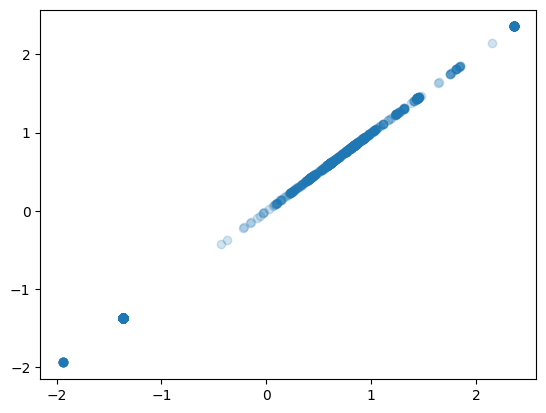

In [21]:
import matplotlib.pyplot as plt

variable_index = 0
plt.scatter(X_max_list[:, variable_index], X_max_list[:, variable_index], alpha=0.2)

In [ ]:
np.mean(np.mean(y_avg, axis=0), axis=0)

array([-6.30359201e-04, -2.76826875e-02, -7.60865505e-01, -5.22171510e-02,
       -2.13618105e-01, -7.88481113e-01, -1.01930234e+00])

In [ ]:
# Regarding mean values of y
print("Mean y minimum values:\n", y_avg.min(axis=0))

print("\n\nMean y average values:\n", y_avg.mean(axis=0))

print("\n\nMean y maximum values:\n", y_avg.max(axis=0))

Mean y minimum values:
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]


Mean y average values:
 [0.32054594 0.05876751 0.01269103 0.05346913 0.17504774 0.22561859
 0.10799521 0.00554481 0.04031898]


Mean y maximum values:
 [1.         0.99120235 0.9521127  1.         1.         1.
 0.97447795 0.9465409  0.97447795]


In [ ]:
y_avg.sum(axis=0)

array([1571.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
      dtype=float32)

# Modelagem

In [22]:
from tensorflow import keras, math
import keras_tuner
from raw_data_manager.models import EventClassType

2023-10-16 14:47:33.489299: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 14:47:33.494439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 14:47:33.549572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 14:47:33.549632: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 14:47:33.549694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Using TensorFlow backend


Função responsável por gerar modelos de acordo com uma lista de hyperparâmetros de entrada.

In [24]:
num_features = X_transformed_ex.shape[2]
num_outputs = len(EventClassType)

def build_model(hp: keras_tuner.HyperParameters):
    # model structure
    model = keras.Sequential()

    model.add(keras.layers.LSTM(
        hp.Int('lstm_units', min_value=5, max_value=100, step=5), 
        activation='relu', 
        input_shape=(transformation_param_num_timesteps_for_window, num_features)))
    
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(
        hp.Int('dense_units', min_value=20, max_value=200, step=10),
        activation='relu'))
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax'))

    # compiling model
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
        metrics=['accuracy'],
    )
    return model

# check the model can compile
build_model(keras_tuner.HyperParameters())

In [27]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory=storage_config.DIR_PROJECT_DATA / "keras_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 100, 'step': 5, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


Realizar a pesquisa pelos melhores hyperparâmetros.

In [28]:
num_epochs = 5
steps_per_epoch = len(train_transformed_file_path_list)

train_data_gen = TransformationManager.data_generator_loop(train_transformed_file_path_list)
validation_data_gen = TransformationManager.data_generator_loop(validation_transformed_file_path_list)
test_data_gen = TransformationManager.data_generator_loop(test_transformed_file_path_list)

tuner.search(
    train_data_gen,
    epochs=num_epochs,
    validation_data=validation_data_gen,
    validation_steps=len(validation_transformed_file_path_list),
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Trial 5 Complete [00h 04m 15s]
val_accuracy: 0.7582585215568542

Best val_accuracy So Far: 0.7582585215568542
Total elapsed time: 00h 19m 01s


Utilizar os parâmetros obtidos que tiveram os melhores resultados para treinar um modelo.

Dessa vez, o modelo será treinado com uma quantidade maior de épocas.

Epoch 1/30
1375/1375 [==============================] - 50s 35ms/step - loss: 1.6094 - accuracy: 0.4878 - val_loss: 1.1262 - val_accuracy: 0.5531
Epoch 2/30
1375/1375 [==============================] - 48s 35ms/step - loss: 0.9575 - accuracy: 0.6881 - val_loss: 0.8230 - val_accuracy: 0.7989
Epoch 3/30
1375/1375 [==============================] - 47s 34ms/step - loss: 0.6812 - accuracy: 0.8129 - val_loss: 0.6993 - val_accuracy: 0.8350
Epoch 4/30
1375/1375 [==============================] - 46s 34ms/step - loss: 0.5160 - accuracy: 0.8726 - val_loss: 0.6015 - val_accuracy: 0.9079
Epoch 5/30
1375/1375 [==============================] - 50s 36ms/step - loss: 0.4215 - accuracy: 0.8997 - val_loss: 0.5034 - val_accuracy: 0.9277
Epoch 6/30
1375/1375 [==============================] - 49s 36ms/step - loss: 0.3674 - accuracy: 0.9020 - val_loss: 0.4525 - val_accuracy: 0.9309
Epoch 7/30
1375/1375 [==============================] - 47s 34ms/step - loss: 0.3275 - accuracy: 0.9052 - val_loss: 0.4195 -

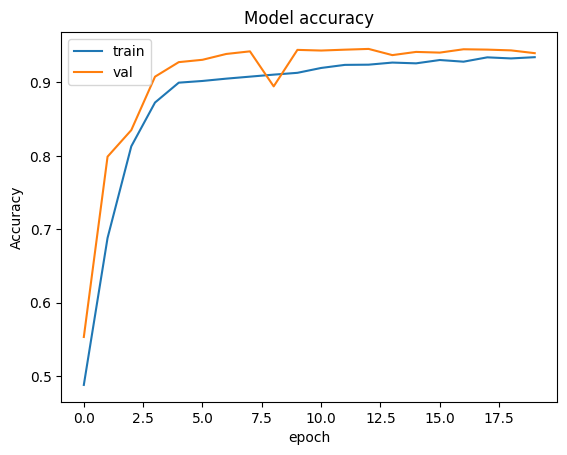

In [40]:
import random
# Training configurations
num_epochs = 30
steps_per_epoch = len(train_transformed_file_path_list)
train_data_gen = TransformationManager.data_generator_loop(
    random.sample(train_transformed_file_path_list.to_list(), steps_per_epoch))
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
best_hps = tuner.get_best_hyperparameters(5)
best_model = build_model(best_hps[0])

training_history = best_model.fit(
    train_data_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_data_gen,
    validation_steps=len(validation_transformed_file_path_list),
    callbacks=[early_stopping_callback, model_checkpoint_callback],
    verbose=1
)

# Graph of training results history
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Ver se está funcionando com um exemplo.

In [ ]:
import numpy as np
test_file = train_transformed_file_path_list[-1]
print(test_file)

Xhat, yhat = TransformationManager.retrieve_pair_array(pathlib.Path(test_file))
print(f"True value: {yhat[0]}")

Xhat0 = Xhat[0].reshape(1, transformation_param_num_timesteps_for_window, num_features)
print(f"Predicted value: {best_model.predict(Xhat0)}")

# Validação
Aqui pegaremos nosso banco de testes, o transformaremos, para então o utilizar para validar a perfomance do nosso modelo.

In [ ]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)
num_steps = len(test_transformed_file_path_list)

best_model.evaluate(
    test_data_gen,
    steps=num_steps,
    verbose=1,
)

In [ ]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)

y_test_predictions = best_model.predict(
    test_data_gen,
)

(
    f"Number of predictions: {len(y_test_predictions)}", 
    f"Shape of y array: {y_test_predictions.shape}", 
    y_test_predictions[0]
)

In [ ]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)
y_test_labels = []

for X, y in test_data_gen:
    y_test_labels.append(y)

y_test_labels = np.concatenate(y_test_labels, axis=0)

(
    f"Number of predictions: {len(y_test_labels)}", 
    f"Shape of y array: {y_test_labels.shape}", 
    y_test_labels[0],
)

In [ ]:
y_test_labels_1d = np.argmax(y_test_labels, axis=1)
y_test_predictions_1d = np.argmax(y_test_predictions, axis=1)

math.confusion_matrix(
    y_test_labels_1d,
    y_test_predictions_1d,
    num_classes=num_outputs,
)